In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import Preprocessing
import Model
import Evaluation
import Pair_Selection

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
dic_similar_20 = pd.read_csv("dic_similar_20.csv")
without_group = pd.read_csv("without_individual.csv")
data = pd.read_csv("user_77_15min.csv")
withoutsolar = pd.read_csv("withoutsolar_15min.csv")
iid = 77

In [3]:
if torch.cuda.is_available():
    print(f"Deploying GPU.")
    device = torch.device("cuda")
else:
    print("GPU is NOT available. CPU will be deployed.")
    device = None

Deploying GPU.


In [4]:
num_withoutsolar = 150
num_withsolar = 172

latitude = 30.29
longitude = -97.69

In [5]:
def transform(y):
    repeat = []
    for i in range(len(y) // 2):
        repeat.append(torch.mean(y[i * 2 : (i + 1) * 2]))
    return torch.repeat_interleave(torch.stack(repeat), repeats=2, dim=0).reshape(
        len(y), 1
    )

In [6]:
def neg_corr(x):
    loss3 = torch.tensor(0.0).to(device)
    x = torch.squeeze(x)
    for k in range(x.shape[0]):
        if x[k] > 0:
            continue
        else:
            loss3 += x[k] ** 2
    return loss3

In [7]:
data = Preprocessing.data_preprocessing(data, longitude, latitude)

In [8]:
data_daytime = data.loc[(data["timeofday"] >= 8) & (data["timeofday"] <= 18)]
data_daytime["minuteofyear"] = data_daytime["timeofday"] * 60 + data_daytime["minute"]

withoutsolar = withoutsolar.loc[
    (withoutsolar["timeofday"] >= 8) & (withoutsolar["timeofday"] <= 18)
]

dic_similar_20.columns = ["id", "group"]
index = dic_similar_20[dic_similar_20["id"] == iid].group.index[0]
candidate = (
    dic_similar_20[dic_similar_20["id"] == iid].group[index].strip()[1:-1].split(",")
)
candidate = [int(i) for i in candidate]

without_group = without_group.loc[without_group["dataid"].isin(candidate)]
without_group = without_group.loc[
    (without_group["timeofday"] >= 8) & (without_group["timeofday"] <= 18)
]

withoutsolar["ave"] = np.array(
    without_group.groupby(["dayofyear", "timeofday", "minute"]).mean()["use"]
)
withoutsolar["consumption"] = np.array(
    without_group.groupby(["dayofyear", "timeofday", "minute"]).sum()["use"]
)
withoutsolar = withoutsolar.sort_values("consumption", ascending=False)

D:\Anaconda\Package\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
withoutsolar.head()

,dayofyear,timeofday,minute,consumption,DHI,DNI,GHI,ave
937,285,18,15,55.831267,52.5,315.0,109.5,2.791563
840,284,18,0,52.638267,73.0,398.0,161.0,2.631913
839,284,17,45,52.191267,84.5,458.0,212.5,2.609563
928,285,16,0,51.931000,118.0,736.0,548.0,2.596550
939,285,18,45,51.212533,19.0,112.0,31.5,2.560627


In [10]:
withoutsolar["minuteofday"] = withoutsolar["timeofday"] * 60 + withoutsolar["minute"]

In [11]:
target_pair_number = 250
p = Pair_Selection.Helper(withoutsolar)
visited = p.pair_selection(data_daytime, withoutsolar, target_pair_number)
df_training = p.training_data_constuct(data_daytime, withoutsolar)

In [12]:
train_data = torch.tensor(np.array(df_training, dtype=float)).to(device)
true_solar = torch.tensor(np.array(df_training.solar, dtype=float)).to(device)
train_net = torch.tensor(np.array(df_training.grid, dtype=float)).to(device)
train_net = train_net.reshape(train_net.shape[0], -1).to(device)

In [13]:
model_train = Model.PhysicalModel(latitude).to(device)
criterion = nn.MSELoss()

withoutsolar = withoutsolar.sort_values(["dayofyear", "timeofday", "minute"])
data_total = torch.tensor(np.array(data_daytime)).to(device)

train_grid = torch.tensor(np.array(data_daytime.grid, dtype=float)).to(device)
train_grid = train_grid.reshape(train_grid.shape[0], -1).to(device)

average = torch.tensor(list(withoutsolar["ave"])).to(device)
average = average.reshape(len(average), -1)

learningRate = 0.05
epochs = 2000
optimizer = torch.optim.Adam(model_train.parameters(), lr=learningRate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.7)

model_train.lower, model_train.upper = 0.087, 0.87

for epoch in range(epochs):

    length = len(train_data)
    y = model_train(train_data).reshape(length, 1)
    y2 = model_train(data_total).reshape(len(data_total), -1)
    y2_predict = y2 + train_grid
    y_predict = y + train_net
    ave = transform(y_predict)
    loss = (
        sum((ave.float() - y_predict.float()) ** 2)
        + sum((model_train.alpha * average.float() - y2_predict.float()) ** 2) * 0.05
        + neg_corr(y2_predict) * 2
    )
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    model_train.beta.data = torch.clip(
        model_train.beta.data, model_train.lower, model_train.upper
    )
    model_train.gamma.data = torch.clip(model_train.gamma.data, 0, 3.1416 * 2)
    model_train.capacity.data = torch.clip(model_train.capacity.data, 0, 1000)
    if epoch % 200 == 0:
        print(f"Training Epochs: {epoch} Training Loss: {loss.item()}")

Training Epochs: 0 Training Loss: 568.46240234375
Training Epochs: 200 Training Loss: 262.94256591796875
Training Epochs: 400 Training Loss: 262.6934814453125
Training Epochs: 600 Training Loss: 262.6483459472656
Training Epochs: 800 Training Loss: 262.6368103027344
Training Epochs: 1000 Training Loss: 262.6330261230469
Training Epochs: 1200 Training Loss: 262.6317138671875
Training Epochs: 1400 Training Loss: 262.6308288574219
Training Epochs: 1600 Training Loss: 262.63037109375
Training Epochs: 1800 Training Loss: 262.630615234375


In [14]:
data_total = torch.tensor(np.array(data)).to(device)
data["prediction"] = model_train(data_total).cpu().detach().numpy()
data["prediction"] = data["prediction"].apply(lambda x: max(0, x))

col = "prediction"
solar_corr = []
for i in range(len(data)):
    if data.iloc[i][col] + data.iloc[i]["grid"] < 0:
        solar_corr.append(-data.iloc[i]["grid"])
    else:
        solar_corr.append(data.iloc[i][col])

data["prediction"] = solar_corr

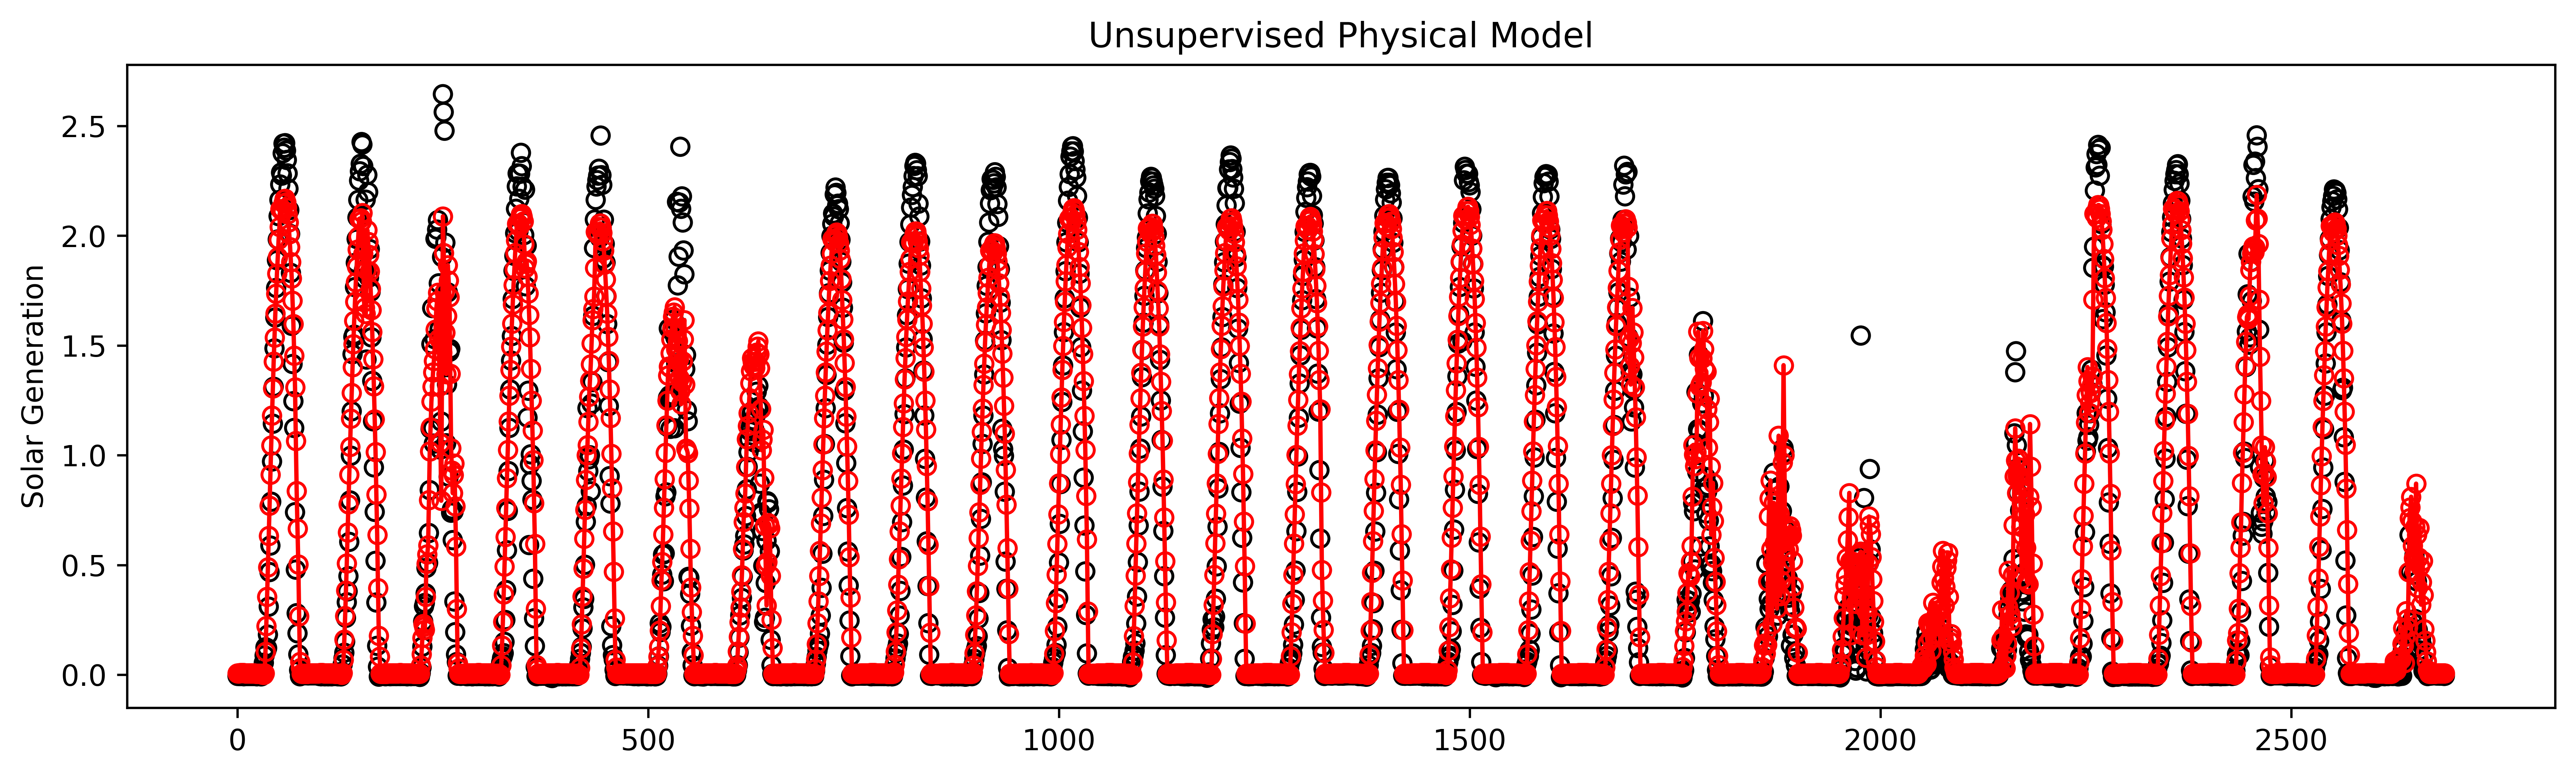

In [15]:
data = data.sort_values(["dayofyear", "timeofday"])
fig = plt.figure(figsize=(15, 4), dpi=600)
plt.scatter(range(len(data)), data.solar, marker="o", c="", edgecolors="black")
plt.plot(
    range(len(data)), data.prediction, marker="o", color="red", markerfacecolor="none"
)
plt.ylabel("Solar Generation")
plt.title("Unsupervised Physical Model")
plt.show()

In [16]:
MSE, MASE, CV = Evaluation.model_evaluation(data)
MSE, MASE, CV

(array([0.03394778]), array([1.79011117]), array([0.40650267]))